# Error analysis
1. Learning curves
2. Classification fails
3. Classification probas

In [70]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import plotly.graph_objects as go

In [75]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1 - Data

In [24]:
train_df = pd.read_feather('./data/train_processed.ftr')
val_df = pd.read_feather('./data/val_processed.ftr')
cols = list(train_df.columns)

In [25]:
train_x = train_df[cols[:-1]].to_numpy()
train_y = train_df[cols[-1]].to_numpy()
val_x = val_df[cols[:-1]].to_numpy()
val_y = val_df[cols[-1]].to_numpy()
X = np.concatenate((train_x, val_x))
y = np.concatenate((train_y, val_y))

## 2 - Model

In [28]:
classifier = lgb.LGBMClassifier(
    boosting='gbdt',
    n_estimators=61,
    max_depth=14,
    learnig_rate=0.43421798862686584,
    num_leaves = 48,
    min_child_samples = 353,
    subsample=0.9876004959374226,
    reg_alpha=0.02075981356072373,
    reg_lambda=0.0803399423062526
)

In [29]:
cv_scores = cross_val_score(classifier, X, y, cv=10)
print(f'Mean cv (k=10) accuracy score = {round(np.mean(cv_scores), 3)}')

Mean cv (k=10) accuracy score = 0.791


In [47]:
classifier.fit(train_x, train_y, eval_set=[(val_x, val_y), (train_x, train_y)], eval_metric=['auc', 'binary_logloss'], verbose=0)

LGBMClassifier(boosting='gbdt', learnig_rate=0.43421798862686584, max_depth=14,
               min_child_samples=353, n_estimators=61, num_leaves=48,
               reg_alpha=0.02075981356072373, reg_lambda=0.0803399423062526,
               subsample=0.9876004959374226)

## 3 - Learning curves

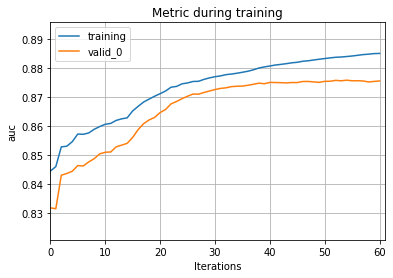

In [50]:
lgb.plot_metric(classifier, 'auc')

C:\Users\TytanowyBartosz\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: more than one metric available, picking one to plot.
  """Entry point for launching an IPython kernel.


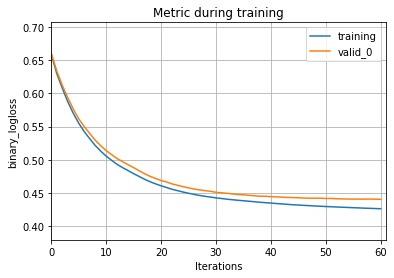

In [51]:
lgb.plot_metric(classifier)

## 4 - Difference between predicitons on train and val sets

In [52]:
y_pred_train = classifier.predict(train_x)
y_pred_val = classifier.predict(val_x)

In [53]:
accuracy_score(train_y, y_pred_train)

0.801314097986002

In [54]:
accuracy_score(val_y, y_pred_val)

0.7966903073286052

## 5 - Failed predictions

In [119]:
y_probas = classifier.predict_proba(val_x)

In [120]:
y_probas = pd.DataFrame(y_probas)
y_probas['prediction'] = y_pred_val
y_probas['prediction'] = y_probas['prediction'].apply(lambda x: 1 if x else 0)
y_probas['true'] = val_y
y_probas['true'] = y_probas['true'].apply(lambda x: 1 if x else 0)

y_probas.sort_values(['true'], inplace=True, ignore_index=True)

In [121]:
y_probas

,0,1,prediction,true
0,0.413841,0.586159,1,0
1,0.413021,0.586979,1,0
2,0.347571,0.652429,1,0
3,0.460388,0.539612,1,0
4,0.864493,0.135507,0,0
...,...,...,...,...
1687,0.032302,0.967698,1,1
1688,0.310249,0.689751,1,1
1689,0.280770,0.719230,1,1
1690,0.557868,0.442132,0,1


In [122]:
y_probas[y_probas['true']==0]

,0,1,prediction,true
0,0.413841,0.586159,1,0
1,0.413021,0.586979,1,0
2,0.347571,0.652429,1,0
3,0.460388,0.539612,1,0
4,0.864493,0.135507,0,0
...,...,...,...,...
807,0.305910,0.694090,1,0
808,0.246671,0.753329,1,0
809,0.478576,0.521424,1,0
810,0.833112,0.166888,0,0


### Graph vars

In [159]:
index = y_probas.index
true_positives = y_probas[(y_probas['prediction']==1) & (y_probas['true']==1)]
true_negatives = y_probas[(y_probas['prediction']==0) & (y_probas['true']==0)]
false_positives = y_probas[(y_probas['prediction']==1) & (y_probas['true']==0)]
false_negatives = y_probas[(y_probas['prediction']==0) & (y_probas['true']==1)]
title = 'Probas and real results on validation set'

In [160]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    name=f'True positives {len(true_positives)}',
    x = true_positives.index,
    y = true_positives[1],
    mode='markers',
    marker_color='rgb(50,200,50)'
))
fig.add_trace(go.Scatter(
    name=f'True negatives {len(true_negatives)}',
    x = true_negatives.index,
    y = true_negatives[1],
    mode='markers',
    marker_color='rgb(100,150,100)'
))

fig.add_trace(go.Scatter(
    name=f'False positives {len(false_positives)}',
    x = false_positives.index,
    y = false_positives[1],
    mode='markers',
    marker_color='rgb(200,50,50)',
    marker=dict(symbol='x')
))
fig.add_trace(go.Scatter(
    name=f'False negatives {len(false_negatives)}',
    x = false_negatives.index,
    y = false_negatives[1],
    mode='markers',
    marker_color='rgb(150,100,100)',
    marker=dict(symbol='x')
))

fig.add_trace(go.Scatter(
    name='True',
    x = index,
    y = y_probas['true'],
    mode='lines',
    marker_color='black'
))

fig.add_trace(go.Scatter(
    name='50%',
    x = index,
    y = [0.5]*len(index),
    mode='lines',
    marker_color='rgba(0,0,0,0.5)'
))

fig.update_layout(title=title)
fig.show()